In [130]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt     
import re
# File Loading
from trace_file_loader import get_breath_df
from lossplots import plot_loss
# SkLearn Packages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# Torch Packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence 
from torch.autograd import Variable
# Warnings
import warnings
warnings.filterwarnings('ignore')

### Experiment:
- Generate fake data with a breathhold between 500 and 4000 points long
- Result: unable to drive testing loss below 0.7

# Generate Fake Data

CNNs assume a fixed input size so we need to assume a fixed size and truncate or pad the sentences as needed.

In [131]:
def fake_data(len_wave):
    bh = np.random.randint(500, 8000)
    x = np.linspace(0, 50, len_wave-bh)
    sinewave = np.sin(x)
    breath = np.array([sinewave[-1]] * bh)
    return np.concatenate((sinewave, breath)), bh   

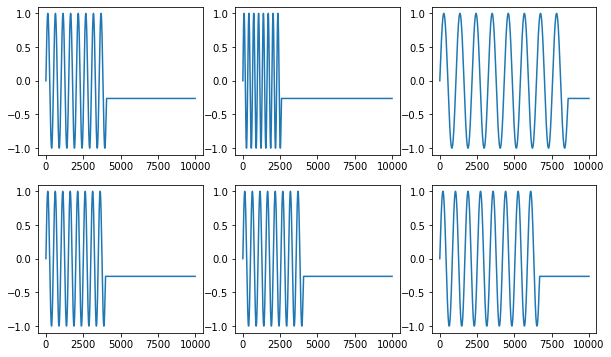

In [132]:
fig, ax = plt.subplots(2,3, figsize = (10,6))
for i in range(2):
    for j in range(3):
        ax[i,j].plot(fake_data(10000)[0])

In [133]:
xs =[]
ys = []
for i in range(10000):
    data = fake_data(10000)
    xs.append(data[0])
    ys.append(data[1])

In [134]:
d = {"Trace":xs, "Breath_hold": ys}
df = pd.DataFrame(d)

In [135]:
q25 = df['Breath_hold'].quantile(.05)
q75 = df['Breath_hold'].quantile(.95)

In [136]:
df = df[(df['Breath_hold'] < q25) | (df['Breath_hold'] > q75)] # only consider breathholds in upper and lower quartiles

In [137]:
df['class'] = np.where(df['Breath_hold'] < q25, 0, 1) # create encoded column: short (0), long (1)


In [138]:
df.head()

,Trace,Breath_hold,class
1,"[0.0, 0.022083010428642334, 0.0441552505575625...",7735,1
3,"[0.0, 0.023275365356107507, 0.0465381197463096...",7851,1
8,"[0.0, 0.005320821972106737, 0.0106414933045771...",602,0
10,"[0.0, 0.0219955863317427, 0.04398052978341853,...",7726,1
12,"[0.0, 0.005305014904148941, 0.0106098805072414...",574,0


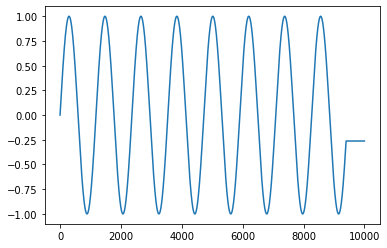

In [139]:
plt.plot(df['Trace'][8])

In [140]:
df['class'].value_counts()

1    500
0    497
Name: class, dtype: int64

# Split and Normalize Data

In [141]:
x_train, x_test, y_train, y_test = train_test_split(df['Trace'], df['class'], test_size=0.20)

In [142]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=1)

In [143]:
def normalize(x_train, x_val):
    u = np.mean([item for sublist in x_train for item in sublist])
    std = np.std([item for sublist in x_train for item in sublist])
    
    train = []
    for row in x_train:
        normalized_row = []
        for x in row:
            normalized_row.append((x-u)/std)
        train.append(normalized_row)
    
    val = []
    for row in x_val:
        normalized_row = []
        for x in row:
            normalized_row.append((x-u)/std)
        val.append(normalized_row)
    
    return train, val

In [144]:
x_train2, x_val2 = normalize(x_train, x_val)
x_train2, x_test2 = normalize(x_train, x_test)

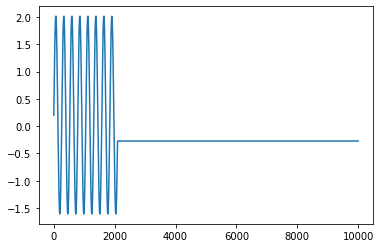

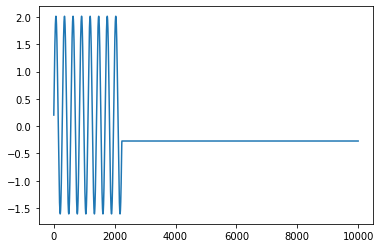

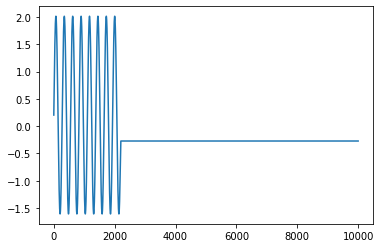

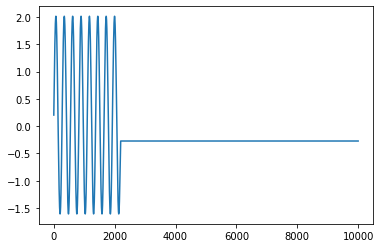

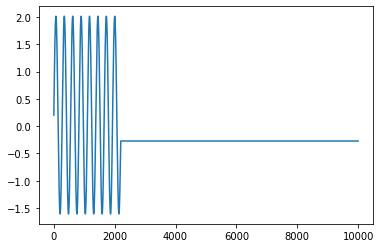

In [145]:
for i in range(5):
    j = np.random.randint(len(x_train2))
    plt.plot(x_train2[j])
    plt.show()

## Re-format Data

In [146]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [147]:
x_train3 = np.array(x_train2)
x_val3 = np.array(x_val2)
x_test3 = np.array(x_test2)

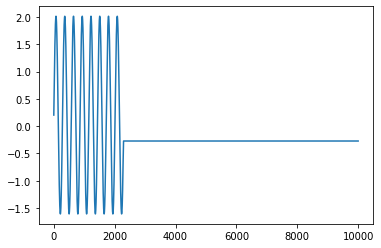

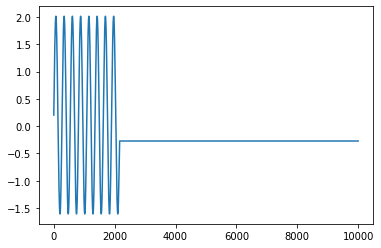

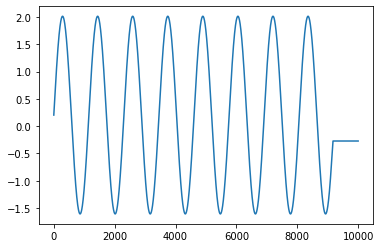

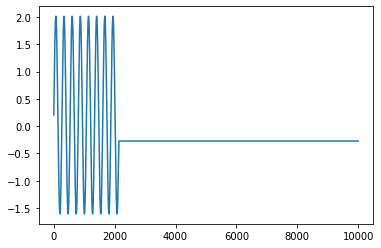

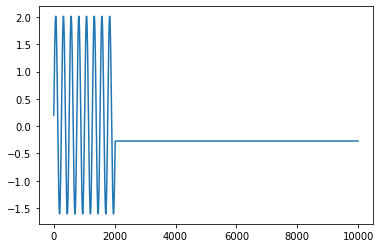

In [148]:
for i in range(5):
    j = np.random.randint(len(x_train3))
    plt.plot(x_train3[j])
    plt.show()

## CNN Model

In [149]:
class myCNN(nn.Module):
    
    def __init__(self, D):
        super(myCNN, self).__init__()
        self.conv_3 = nn.Conv1d(in_channels=1, out_channels=200, kernel_size=3)
        self.conv_4 = nn.Conv1d(in_channels=1, out_channels=200, kernel_size=4)
        self.conv_5 = nn.Conv1d(in_channels=1, out_channels=200, kernel_size=5)
        self.fc = nn.Linear(600, 1)
        
    def forward(self, x):
        x = torch.unsqueeze(x, dim=1)
        x3 = F.relu(self.conv_3(x))
        x4 = F.relu(self.conv_4(x))
        x5 = F.relu(self.conv_5(x))
        
        x3 = nn.MaxPool1d(kernel_size = 9998)(x3)
        x4 = nn.MaxPool1d(kernel_size = 9997)(x4)
        x5 = nn.MaxPool1d(kernel_size = 9996)(x5)
        
        out = torch.cat([x3, x4, x5], 2)
        out = out.view(out.size(0), -1)
        
        return self.fc(out) 

In [150]:
# Testing the model
model = myCNN(1)

In [151]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(model)

+---------------+------------+
|    Modules    | Parameters |
+---------------+------------+
| conv_3.weight |    600     |
|  conv_3.bias  |    200     |
| conv_4.weight |    800     |
|  conv_4.bias  |    200     |
| conv_5.weight |    1000    |
|  conv_5.bias  |    200     |
|   fc.weight   |    600     |
|    fc.bias    |     1      |
+---------------+------------+
Total Trainable Params: 3601


3601

In [152]:
for name, param in model.named_parameters():
    print(name, '\t\t', param.shape)

conv_3.weight 		 torch.Size([200, 1, 3])
conv_3.bias 		 torch.Size([200])
conv_4.weight 		 torch.Size([200, 1, 4])
conv_4.bias 		 torch.Size([200])
conv_5.weight 		 torch.Size([200, 1, 5])
conv_5.bias 		 torch.Size([200])
fc.weight 		 torch.Size([1, 600])
fc.bias 		 torch.Size([1])


In [153]:
x = x_train3[:10]
x = torch.tensor(x,dtype=torch.float32)
model(x)

tensor([[0.1601],
        [0.1601],
        [0.1601],
        [0.1601],
        [0.1606],
        [0.1606],
        [0.1602],
        [0.1606],
        [0.1602],
        [0.1606]], grad_fn=<AddmmBackward0>)

# Dataset and Dataloader

In [154]:
from torch.utils.data import Dataset

class timeseries(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.len = x.shape[0]

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
  
    def __len__(self):
        return self.len

In [155]:
dataset = timeseries(x_train3, y_train)
valid_dataset = timeseries(x_val3,y_val)
test_dataset = timeseries(x_test3,y_test)

In [156]:
train_loader = DataLoader(dataset,shuffle=False,batch_size=50)
val_loader = DataLoader(valid_dataset,shuffle=False,batch_size=50)
test_loader = DataLoader(test_dataset,shuffle=False,batch_size=50)

In [157]:
dataset.x.shape

torch.Size([478, 10000])

In [158]:
dataset.y[0:10]

tensor([1., 1., 1., 1., 0., 0., 1., 0., 1., 0.])

## Training

In [159]:
model = myCNN(1).cuda()

In [160]:
parameters = filter(lambda p: p.requires_grad, model.parameters())

In [161]:
def train_epocs(model, epochs=10, lr=0.01, fname='1'):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    
    losses = []
    for i in range(epochs):
        model.train()
        current_loss = []
        for x, y in train_loader:
            x = x.cuda()
            y = y.unsqueeze(1).cuda()
            y_hat = model(x)
            loss = F.binary_cross_entropy_with_logits(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            current_loss.append(loss.item())
        train_loss = np.mean(current_loss)
        print('Epoch:', i)
        print("Train loss:", train_loss)
        val_loss = test_metrics(model)
        losses.append((train_loss, val_loss))
        
        
    #filename = 'losses_' + fname + '.csv'
    #np.savetxt(filename, losses, delimiter=",")
    return losses

In [162]:
def test_metrics(m):
    m.eval()
    losses = []
    for x, y in val_loader:
        x = x.cuda()
        y = y.unsqueeze(1).cuda()
        y_hat = m(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y)
        losses.append(loss.item())
        
        y_pred = y_hat > 0
        correct = (y_pred.float() == y).float().sum()
        accuracy = correct/y_pred.shape[0]
    print("test loss %.3f and accuracy %.3f" % (np.mean(losses), accuracy))
    return np.mean(losses)

In [163]:
loss = train_epocs(model, epochs=20, lr=0.01)

Epoch: 0
Train loss: 1.3031452655792237
test loss 0.720 and accuracy 0.632
Epoch: 1
Train loss: 0.7903446197509766
test loss 0.696 and accuracy 0.368
Epoch: 2
Train loss: 0.726735132932663
test loss 0.712 and accuracy 0.368
Epoch: 3
Train loss: 0.717159754037857
test loss 0.735 and accuracy 0.368
Epoch: 4
Train loss: 0.7211955487728119
test loss 0.757 and accuracy 0.368
Epoch: 5
Train loss: 0.7274376451969147
test loss 0.769 and accuracy 0.368
Epoch: 6
Train loss: 0.7309241950511932
test loss 0.765 and accuracy 0.368
Epoch: 7
Train loss: 0.7288092792034149
test loss 0.751 and accuracy 0.368
Epoch: 8
Train loss: 0.7245934426784515
test loss 0.733 and accuracy 0.368
Epoch: 9
Train loss: 0.7178792536258698
test loss 0.717 and accuracy 0.368
Epoch: 10
Train loss: 0.7081564426422119
test loss 0.703 and accuracy 0.368
Epoch: 11
Train loss: 0.6992359101772309
test loss 0.697 and accuracy 0.368
Epoch: 12
Train loss: 0.6922967553138732
test loss 0.690 and accuracy 0.368
Epoch: 13
Train loss: 0.

In [164]:
loss2 = train_epocs(model, epochs=20, lr=0.01)

Epoch: 0
Train loss: 0.7341288149356842
test loss 0.714 and accuracy 0.368
Epoch: 1
Train loss: 0.6638782382011413
test loss 0.669 and accuracy 0.368
Epoch: 2
Train loss: 0.6398432612419128
test loss 0.626 and accuracy 0.368
Epoch: 3
Train loss: 0.6088739991188049
test loss 0.592 and accuracy 1.000
Epoch: 4
Train loss: 0.5777654826641083
test loss 0.564 and accuracy 1.000
Epoch: 5
Train loss: 0.5489321410655975
test loss 0.537 and accuracy 1.000
Epoch: 6
Train loss: 0.5213203072547913
test loss 0.505 and accuracy 1.000
Epoch: 7
Train loss: 0.4933509737253189
test loss 0.481 and accuracy 1.000
Epoch: 8
Train loss: 0.4660260945558548
test loss 0.454 and accuracy 1.000
Epoch: 9
Train loss: 0.43765155375003817
test loss 0.432 and accuracy 1.000
Epoch: 10
Train loss: 0.4137629270553589
test loss 0.417 and accuracy 1.000
Epoch: 11
Train loss: 0.3948669761419296
test loss 0.396 and accuracy 1.000
Epoch: 12
Train loss: 0.37066422402858734
test loss 0.361 and accuracy 1.000
Epoch: 13
Train loss

In [165]:
loss3 = train_epocs(model, epochs=20, lr=0.001)

Epoch: 0
Train loss: 0.1816873788833618
test loss 0.174 and accuracy 1.000
Epoch: 1
Train loss: 0.17275707870721818
test loss 0.168 and accuracy 1.000
Epoch: 2
Train loss: 0.16744370609521866
test loss 0.163 and accuracy 1.000
Epoch: 3
Train loss: 0.16202354431152344
test loss 0.158 and accuracy 1.000
Epoch: 4
Train loss: 0.15711847841739654
test loss 0.153 and accuracy 1.000
Epoch: 5
Train loss: 0.15210348963737488
test loss 0.148 and accuracy 1.000
Epoch: 6
Train loss: 0.1474341034889221
test loss 0.143 and accuracy 1.000
Epoch: 7
Train loss: 0.14277736991643905
test loss 0.139 and accuracy 1.000
Epoch: 8
Train loss: 0.13861811012029648
test loss 0.135 and accuracy 1.000
Epoch: 9
Train loss: 0.13452233821153642
test loss 0.131 and accuracy 1.000
Epoch: 10
Train loss: 0.1305890403687954
test loss 0.127 and accuracy 1.000
Epoch: 11
Train loss: 0.12682953774929046
test loss 0.124 and accuracy 1.000
Epoch: 12
Train loss: 0.1231664091348648
test loss 0.120 and accuracy 1.000
Epoch: 13
Tra

In [45]:
loss = train_epocs(model, epochs=20, lr=0.0001)

Epoch: 0
Train loss: 0.690853226184845
test loss 0.704 and accuracy 0.300
Epoch: 1
Train loss: 0.6905783295631409
test loss 0.704 and accuracy 0.300
Epoch: 2
Train loss: 0.6905274510383606
test loss 0.704 and accuracy 0.300
Epoch: 3
Train loss: 0.6904983043670654
test loss 0.704 and accuracy 0.300
Epoch: 4
Train loss: 0.690487015247345
test loss 0.704 and accuracy 0.300
Epoch: 5
Train loss: 0.690476906299591
test loss 0.704 and accuracy 0.300
Epoch: 6
Train loss: 0.6904693245887756
test loss 0.704 and accuracy 0.300
Epoch: 7
Train loss: 0.6904608964920044
test loss 0.704 and accuracy 0.300
Epoch: 8
Train loss: 0.6904552817344666
test loss 0.704 and accuracy 0.300
Epoch: 9
Train loss: 0.6904483675956726
test loss 0.704 and accuracy 0.300
Epoch: 10
Train loss: 0.69044189453125
test loss 0.704 and accuracy 0.300
Epoch: 11
Train loss: 0.69043869972229
test loss 0.704 and accuracy 0.300
Epoch: 12
Train loss: 0.690433394908905
test loss 0.704 and accuracy 0.300
Epoch: 13
Train loss: 0.690427

# Loss Plots

In [ ]:
val = [x[1] for x in losses]
train = [x[0] for x in losses]